<a href="https://colab.research.google.com/github/ncadavia/OPI_Analytics_/blob/main/OPI_Analytics_SeccionA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/OPI_Analytics/"

/content/drive/MyDrive/OPI_Analytics


In [ ]:
ls

 bops_bm.csv      bops_online.csv                      diccionarios.xlsx
'BOPS Case.pdf'   carpetas_completa_febrero_2022.csv


In [ ]:
# Importamos las librerías y módulos necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Leemos la carpetas de investigación de la FGJ
df_ = pd.read_csv("carpetas_completa_febrero_2022.csv", low_memory=False)

# <center> Preprocesamiento de datos sección A</center>

In [ ]:
# Revisando los datos, podemos ver que para años (ao_hechos) anteriores a 2016
# los reportes acumulados por delito en cada año son muy pocos en comparación
# con el promedio por delito en el rango de años (ao_hechos) de 2016 a 2021,
# por lo tanto solo consideramos las observaciones cuyo ao_hechos sean mayores a
# 2015
# Código para ver los reportes por delito acumulado por año (ao_hechos):
# dfj = df_.copy() 
# dfj['to_count'] = [1]*len(dfj)
# for d in dfj.delito.unique():
#     dfj1 = dfj[dfj.delito==d]
#     dfj2 = dfj1.groupby('ao_hechos')['to_count'].sum()
#     print(dfj2)
df_ = df_[~df_.fecha_hechos.isna()]
df_ = df_[df_.ao_hechos>=2016]

# Quitamos la columna tempo que solo contiene valores NaN 
df_.drop("tempo", axis=1 , inplace=True)

# Creamos df1 como el dataframe que en la columna alcaldia_hechos contiene solo
# las alcaldías de CDMX, pues tal columna contiene lugares diferentes a las 16
# alcaldias de CDMX
alcaldias_cdmx = ["ALVARO OBREGON", "AZCAPOTZALCO", "BENITO JUAREZ", "COYOACAN",
"CUAJIMALPA DE MORELOS", "CUAUHTEMOC", "GUSTAVO A MADERO", "IZTACALCO",
"IZTAPALAPA", "LA MAGDALENA CONTRERAS", "MIGUEL HIDALGO", "MILPA ALTA",
"TLALPAN", "TLAHUAC", "VENUSTIANO CARRANZA", "XOCHIMILCO"]
df1 = df_[df_['alcaldia_hechos'].isin(alcaldias_cdmx)]

# <center> Sección A </center>

---
**1. ¿Qué pruebas identificarías para asegurar la calidad de estos datos? No es necesario
hacerlas, sólo describe la prueba y lo que te dice cada una.**

Para asegurar la calidad de los datos:


1.   Haría un análisis exploratorio de datos (EDA)  con el objetivo de buscar datos nulos, campos vacíos, formatos erróneos, datos erróneos, faltas de ortografía, datos duplicados, etc. Por ejemplo, con la librería `pandas`, una forma de validar los datos consiste en usar:

*   la función `info()`, la cual nos proporciona un resumen acerca del número de entradas y columnas, además, por columna nos proporciona información acerda de datos faltantes y del tipo de datos. 
*    la función `describe()`, la cual  calcula estadísticas de resumen como la media, la desviación estándar, el mínimo y el máximo para columnas númericas.
* el método `drop_duplicates()`, el cual nos ayuda a eliminar registros duplicados.

2.   Si el conjunto de datos con el que estoy trabajando no es muy grande, usaría además pandas-profiling, que nos permite obtener la misma información de las funciones y métodos ya mencionados, pero además, proporciona otros detalles como: correlaciones, histogramas, valores extremos ó valores comúnes.



---
**2. Identifica los delitos que van a la alza y a la baja en la CDMX (ten cuidado con los delitos con pocas ocurrencias).**

Para responder esta pregunta primero vamos a encontrar, en términos de percentiles, qué entenderemos por un delito con pocas ocurrencias, de la siguiente manera:

1.   Contamos cuántas veces un delito es reportado, obteniendo el resultado en una serie cuyos valores están en orden ascendente.
2.   Después exploraremos los percentiles de tal serie y en términos de estos, decidiremos cuándo un delito es de poca ocurrencia (pues como usaremos series de tiempo más adelante, necesitamos delitos cuyo acumulado de ocurrencias no sea inferior a 30, pues son muy pocos datos para debelar patrones/estructuras de tiempo).



In [ ]:
cant_delitos = df1.delito.value_counts().sort_values(ascending=True)
display(cant_delitos.tail(5))
print("\nLos percentiles correspondientes:\n")
[np.round(k, 0) for k in cant_delitos.quantile([0.1, 0.25, 0.5, 0.75, 1])]

ROBO A NEGOCIO SIN VIOLENCIA     68382
AMENAZAS                         77278
ROBO DE OBJETOS                  79957
FRAUDE                           81856
VIOLENCIA FAMILIAR              148833
Name: delito, dtype: int64


Los percentiles correspondientes:



[6.0, 35.0, 286.0, 1904.0, 148833.0]

Así, un delito será considerado de poca ocurrencia si el total de sus ocurrencia suma menos de 36. Ahora, para determinar cuáles delitos van al alza y a la baja en CDMX, dejamos en nuestro conjunto de datos aquellas observaciones que constan de los delitos con ocurrencia superior a 35 (ver función `get_df_mayor_crimes`) y después con la función `variacion_delitos` vemos, con una temporalidad anual, cuáles delitos van al alza y a la baja.

In [ ]:
def get_df_mayor_crimes(df, min_crimes=35):
    """
    Recibe un dataframe y el número mínimo de ocurrencias.
    Devuelve un slice del dataframe recibido bajo la condición de que al ver un 
    delito cuyo acumulado sea superior al min_crimes esté en este nuevo dataframe.
    """
    count_crimes = df.delito.value_counts().sort_values(ascending=True)
    l = len([k for k in range(len(count_crimes)) if count_crimes[k]<=min_crimes])
    count_crimes1 = count_crimes[l:].reset_index()
    count_crimes2 = count_crimes1['index'].to_list()
    return df[df.delito.isin(count_crimes2)]

def variacion_delitos(df, temp='ao'):
    """
    Recibe un dataframe y una temporalidad, puede ser anual 'ao' o mensual 'mes'.
    Devuelve un par de listas alza, baja donde:
       alza: es una lista que contiene delitos que han ido en aumento de acuerdo 
       a la temporalidad
       baja: es una lista que contiene delitos que han ido en decremento de
       acuerdo a la temporalidad
    """
    alza = []
    baja = []
    df_altas_ocu =  get_df_mayor_crimes(df)
    for d in df_altas_ocu.delito.unique():
        df_1 = df_altas_ocu[df_altas_ocu.delito==d]
        df_1['to_count'] = [1] * len(df_1)
        df_2 = df_1.groupby(temp+'_hechos')['to_count'].sum()
        numbers = df_2.to_list()
        if all([numbers[k]>=numbers[k-1] for k in range(1,len(numbers))]):
            alza.append(d)
        elif all([numbers[k]<=numbers[k-1] for k in range(1,len(numbers))]):
            baja.append(d)
        else:
             pass
    return alza, baja
a, b = variacion_delitos(df1)

De acuerdo a los resultados obtenidos con `variacion_delitos` tenemos que los delitos que van al alza en CDMX son los elementos de `a`:

In [ ]:
a

['FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMENTOS DE CREDITO PUBLICO',
 'ABUSO DE AUTORIDAD',
 'PORTACION ARMA/PROHIB.',
 'PORNOGRAFIA INFANTIL',
 'ALLANAMIENTO DE MORADA',
 'ROBO A PASAJERO A BORDO DE TAXI SIN VIOLENCIA',
 'USURPACION DE FUNCIONES',
 'OTROS CULPOSOS',
 'RETENCIÓN O SUSTRACCIÓN DE MENORES INCAPACES',
 'ENCUBRIMIENTO POR FAVORECIMIENTO Y RECEPTACIÓN']

y los delitos que van a la baja en CDMX son los elementos de `b`:

In [ ]:
b

['FALSEDAD DE DECLARACIONES',
 'ROBO DE VEHICULO DE SERVICIO DE TRANSPORTE CON VIOLENCIA',
 'ROBO DE VEHICULO DE SERVICIO PÚBLICO SIN VIOLENCIA',
 'INSOLVENCIA ALIMENTARIA',
 'FALSIFICACION DE SELLOS, MARCAS, LLAVES Y OTROS',
 'EJERCICIO INDEBIDO DEL SERVIDOR PUBLICO',
 'ROBO DE CONTENEDORES DE TRAILERS S/V',
 'ROBO A NEGOCIO CON VIOLENCIA POR FARDEROS (TIENDAS DE AUTOSERVICIO)',
 'ROBO A LOCALES SEMIFIJOS (PUESTOS DE ALIMENTOS,BEBIDAS, ENSERES, PERIODICOS,LOTERIA, OTROS)']

---
**3. ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?¿Por qué crees que sea esto?**

A continuación vemos el número de delitos reportado en cada una de las alcaldías:

In [ ]:
print(df1[['alcaldia_hechos']].value_counts())

alcaldia_hechos       
CUAUHTEMOC                209583
IZTAPALAPA                206220
GUSTAVO A MADERO          138880
BENITO JUAREZ             111403
ALVARO OBREGON             93548
COYOACAN                   92162
MIGUEL HIDALGO             88019
TLALPAN                    80982
VENUSTIANO CARRANZA        79111
AZCAPOTZALCO               67178
IZTACALCO                  57567
XOCHIMILCO                 43382
TLAHUAC                    35022
LA MAGDALENA CONTRERAS     22882
CUAJIMALPA DE MORELOS      20639
MILPA ALTA                 10385
dtype: int64


De acuerdo con estos valores la alcaldía que más delitos tiene es `CUAUHTEMOC` con `209583` casos reportados y, la que menos, `MILPA ALTA` con `10385` casos reportados. Ahora, ahondando en los principales delitos que se cometieron en cada una de las alcaldías entre 2016 y lo reportado a 2022, tenemos que (de acuerdo a los valores que se pueden ver en los resultados de la celda de código siguiente a mi respuesta):
* En la alcaldía `CUAUHTEMOC` los cinco principales delitos son:
```
FRAUDE                                            19713
ROBO DE OBJETOS                                   15372
VIOLENCIA FAMILIAR                                11992
ROBO A NEGOCIO SIN VIOLENCIA                      11045
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA    10204
```
Esto podría deberse a que en esta alcaldía se encuentran las colonias:
 * Santa María-Tlatelolco,
 * Tepito-Guerrero,
 * Juárez-San Rafael,
 * Centro Histórico,
 * Roma-Condesa y 
 * Obrera-Doctores, 

 varias de las cuales son susceptibles a una alta actividad comercial y turística, otras albergan instituciones gubernamentales y embajadas. Además de que, por supuesto, hay zonas residenciales.

* En la alcaldía `MILPA ALTA` los cinco principales delitos son:
```
VIOLENCIA FAMILIAR                      2508
AMENAZAS                                 747
ROBO A CASA HABITACION SIN VIOLENCIA     399
ROBO DE OBJETOS                          374
DESPOJO                                  344
```
Esto podría deberse a que es la alcaldía más despoblada de la ciudad y su población se encuentra dividida en varios pueblos, los cuales por supuesto son susceptibles de estos delitos típicos.

In [ ]:
# Código en el que basé mi respuesta a la pregunta 3
df2 = df1[df1['ao_hechos']>=2016]
df3 = get_df_mayor_crimes(df2)
cuau = df3[df3['alcaldia_hechos'] == 'CUAUHTEMOC']
cuau2 = get_df_mayor_crimes(cuau)
print("CUAUHTEMOC:\n")
display(cuau2.delito.value_counts()[:5])
print("\nMILPA ALTA:\n")
milpa = df3[df3['alcaldia_hechos'] == 'MILPA ALTA']
milpa2 = get_df_mayor_crimes(milpa)
display(milpa2.delito.value_counts()[:5])

CUAUHTEMOC:



FRAUDE                                            19713
ROBO DE OBJETOS                                   15372
VIOLENCIA FAMILIAR                                11992
ROBO A NEGOCIO SIN VIOLENCIA                      11045
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA    10204
Name: delito, dtype: int64


MILPA ALTA:



VIOLENCIA FAMILIAR                      2508
AMENAZAS                                 747
ROBO A CASA HABITACION SIN VIOLENCIA     399
ROBO DE OBJETOS                          374
DESPOJO                                  344
Name: delito, dtype: int64

---
4. ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la
semana, quincenas) en la CDMX?¿A qué crees que se deba?

Para responder a esta pregunta, en el caso general, obtenemos una serie de tiempo a partir del dataframe con una frecuencia que puede variar entre semanal y trimestral. Después realizamos una gráfica para cada año desde el 2016 al 2021  con el fin de detectar algún tipo de comportamiento estacional (ver función `plot_delitos`). No consideramos los datos del 2022 dado que son pocos. 

Luego nos enfocaremos en los delitos con mayor ocurrencia: `ROBO DE OBJETOS`, `FRAUDE` y `VIOLENCIA FAMILIAR`, con los que obtendremos una serie de tiempo del slice del dataframe, correspondiente a cada uno de estos y con una frecuencia que puede variar entre semanal y trimestral. Al igual que en el caso general, se realiza una gráfica para cada año desde el 2016 al 2021 con el fin de detectar algún tipo de comportamiento estacional (al igual que antes no consideramos 2022). Con el fin de validar si existe estacionalidad o no en estos casos, usamos la función `seasonal_decompose` de la librería `StatsModels` para descomponer la serie de tiempo en sus componentes estacional, de tendencia y residual. Y nos fijaremos si la gráfica de la componente residual, en efecto corresponde o no a ruido blanco, si no corresponde entonces descartamos tendencial estacional para el delito.


In [ ]:
def delito_serie(df, delit='all', temp='M'):
    """
    Recibe un dataframe, un delito sobre el cuál hacer el slice y la frecuencia
    que nos interesa considerar (semana, mes, trimestre, semestre)
    Devuelve un slice del dataframe correspondiente al delito seleccionado como 
    una serie de tiempo
    """
    df_c = df.copy()
    df_c = df_c[df_c.ao_hechos<2022]
    df_c['fecha_hechos'] = pd.to_datetime(df_c['fecha_hechos'])
    df_c = df_c.set_index('fecha_hechos')
    df_c['to_count'] = [1] * len(df_c)
    if delit == 'all':
        df_c1 = df_c.copy()
    else:
        df_c1 = df_c[df_c.delito==delit]
    DF = df_c1.resample(temp)['to_count'].sum()
    return DF

In [ ]:
def plot_delitos(df, delit='all', temp='M'):
    """
    Recibe un dataframe, un delito sobre el cuál hacer el slice y la frecuencia
    que nos interesa considerar (semana, mes, trimestre, semestre)
    Esta función no devuelva nada, solo grafica las series de tiempo
    """
    df2 = df1.copy()
    df2 = df2[df2.ao_hechos<2022]
    df2['fecha_hechos'] = pd.to_datetime(df2['fecha_hechos'])
    df2 = df2.set_index('fecha_hechos')
    df2['to_count'] = [1] * len(df2)
    if delit == 'all':
        df3 = df2.copy()
    else:
        df3 = df2[df2.delito==delit]
    DF = pd.DataFrame()
    for y in df3.ao_hechos.unique():
        df4 = df3[df3.ao_hechos == y]
        df5 = df4.resample(temp)['to_count'].sum().reset_index()
        df5['fecha_hechos'] = df5.fecha_hechos.apply(lambda t: str(t)[5:10])
        df5 = df5.rename(columns={'fecha_hechos': 'fecha_hechos'+str(int(y)), 'to_count': str(int(y))})
        DF = pd.concat([DF, df5], axis=1)
    DF1 = DF[['fecha_hechos2016', '2016', '2017', '2018', '2019', '2020', '2021']]
    DF1.plot(x="fecha_hechos2016", figsize=(15,7))
    plt.show()

Dada la siguiente gráfica, vemos que para todos los delitos, parece haber una tendencia estacional, al alza, en el mes de octubre. Tal vez se deba a que inicia la temporada de finde año. 

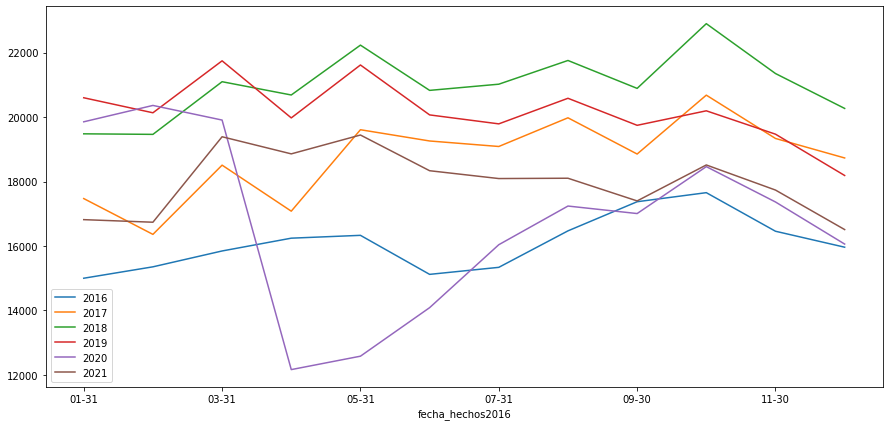

In [ ]:
plot_delitos(df3, delit='all', temp='M')

En el caso de **ROBO DE OBJETOS**:

Dada la siguiente gráfica, parece haber una tendencia estacional, a la baja, en el mes de septiembre, módulo el año de pandemia. No tengo hipótesis claras respecto a esta posible estacionalidad.

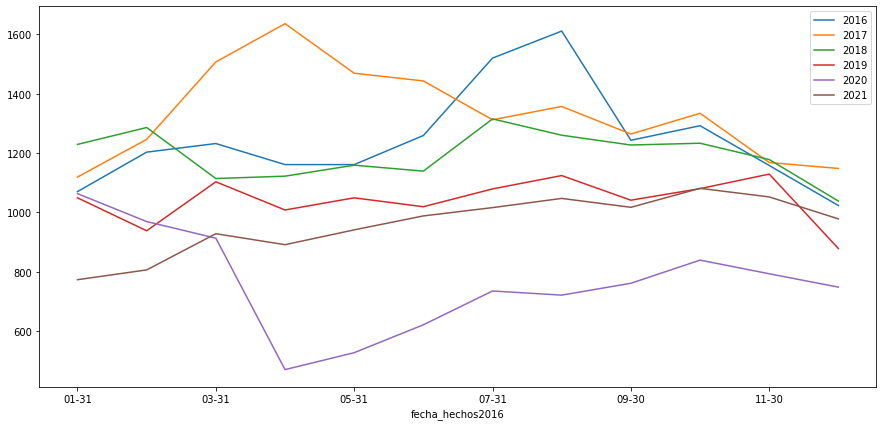

In [ ]:
plot_delitos(df3, delit='ROBO DE OBJETOS', temp='M')

Ahora, usando `seasonal_decompose`, vemos que la gráfica de residuales no parece ruido blanco, pues no parece una gráfica donde los valores oscilan alrededor del 0.

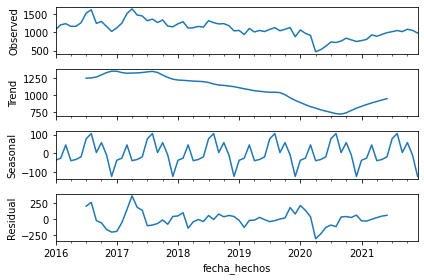

In [ ]:
df_robo_obj = delito_serie(df3, delit='ROBO DE OBJETOS', temp='M')
decomp = seasonal_decompose(df_robo_obj)
decomp.plot()
plt.show()

En el caso de **VIOLENCIA FAMILIAR**:
Dada la siguiente gráfica, parece haber una tendencia estacional, al alza, en los meses de marzo y mayo, módulo el año 2016 en el primer caso y el año de pandemia el segundo. En marzo podría deberse al día de la mujer y en mayo a las festividades del día de madres.

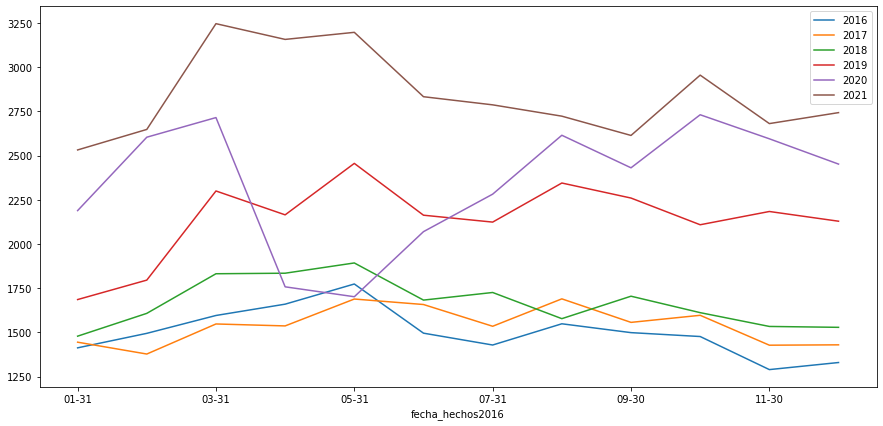

In [ ]:
plot_delitos(df3, delit='VIOLENCIA FAMILIAR', temp='M')

Ahora, usando `seasonal_decompose`, vemos que la gráfica de residuales no parece ruido blanco, pues no parece una gráfica donde los valores oscilan alrededor del 0.

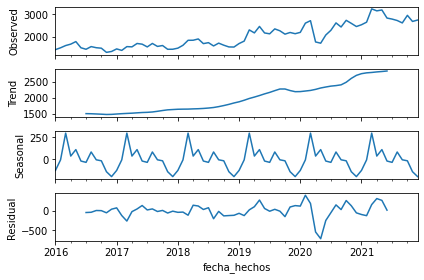

In [ ]:
df_robo_obj = delito_serie(df3, delit='VIOLENCIA FAMILIAR', temp='M')
decomp = seasonal_decompose(df_robo_obj)
decomp.plot()
plt.show()

En el caso de **FRAUDE**:
Dada la siguiente gráfica, parece haber una tendencia estacional, al alza, en el mes de octubre. Tal vez de se deba a que inicia temporada de fin de año y se requiere acelerar trámites, ejecutar presupuestos, etc.

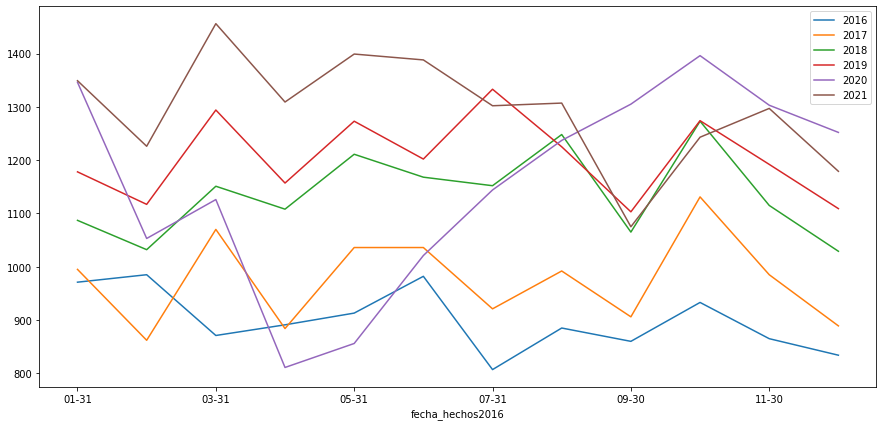

In [ ]:
plot_delitos(df3, delit='FRAUDE', temp='M')

Ahora, usando `seasonal_decompose`, vemos que la gráfica de residuales se asemeja un poco más a ruido blanco.

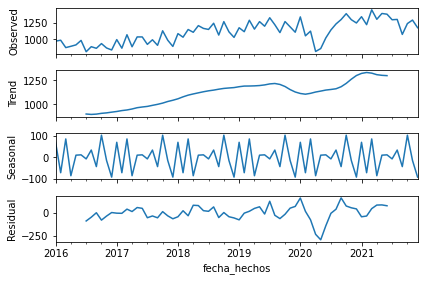

In [ ]:
df_robo_obj = delito_serie(df3, delit='FRAUDE', temp='M')
decomp = seasonal_decompose(df_robo_obj)
decomp.plot()
plt.show()

---
5. ¿Cuáles son los delitos que más caracterizan a cada alcaldía? Es decir, delitos que
suceden con mayor frecuencia en una alcaldía y con menor frecuencia en las demás.

Para llegar a la respuesta de esta pregunta se crea la función `delitos_caracterizan` (ver código abajo), la cual toma como argumentos un dataframe y una alcaldía y, determina por delito, cuál es la alcaldía donde ocurre con mayor frecuencia el mismo. Luego iteramos sobre cada alcaldía de CDMX, para ver qué delitos la caracterizan.

De los resultados obtenidos, vemos que no hay delitos que sucedan con mayor frecuencia en `COYOACAN`, `CUAJIMALPA DE MORELOS`,
`LA MAGDALENA CONTRERAS` ni `MILPA ALTA` y con menor frecuencia en las demás.

In [ ]:
def delitos_caracterizan(df, alcaldia='GUSTAVO A MADERO'):
    """
    Recibe un dataframe y el nombre de la alcaldia.
    Devuelve los delitos que ocurren más frecuentemente en esta alcaldía y con
    menor frecuencia en las demás
    """
    delitos = []
    for d in df.delito.unique():
        df1 = df[df.delito==d]
        df1['to_count'] = [1] * len(df1)
        df2 = df1.groupby('alcaldia_hechos')['to_count'].sum()
        if alcaldia in df2.index.to_list():
            if df2[alcaldia] == df2.max():
                delitos.append(d)
            else:
                pass
        else:
            pass
    return delitos

for alcaldia in alcaldias_cdmx:
  deli = delitos_caracterizan(df3, alcaldia=alcaldia)
  print("A la alcaldía {} la caracterizan los siguientes delitos:\n".format(alcaldia))
  print(*deli, sep="\n")
  print("\n\n")

A la alcaldía ALVARO OBREGON la caracterizan los siguientes delitos:

ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA
SECUESTRO EXPRESS (PARA COMETER ROBO O EXTORSIÓN)
ROBO DE MAQUINARIA SIN VIOLENCIA
USO INDEBIDO DE ATRIBUCIONES Y FACULTADES



A la alcaldía AZCAPOTZALCO la caracterizan los siguientes delitos:

ROBO A TRANSEUNTE EN NEGOCIO CON VIOLENCIA
ROBO A TRANSEUNTE EN PARQUES Y MERCADOS CON VIOLENCIA
ROBO A TRANSPORTISTA Y VEHICULO PESADO SIN VIOLENCIA
CONTRA EL ESTADO CIVIL
ROBO DE CONTENEDORES DE TRAILERS S/V
ROBO DE MERCANCIA EN CONTENEDEROS EN ÁREAS FEDERALES



A la alcaldía BENITO JUAREZ la caracterizan los siguientes delitos:

ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO
FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMENTOS DE CREDITO PUBLICO
ROBO DE ACCESORIOS DE AUTO
ROBO A TRANSEUNTE EN RESTAURANT CON VIOLENCIA
VIOLACION DE CORRESPONDENCIA
REVELACION DE SECRETOS
PERDIDA DE LA VIDA POR DERRUMBE
ROBO EN INTERIOR DE EMPRESA (NOMINA) SIN VIOLENCIA
PRODUCCIÓN, IMPRESIÓN, E

6. Diseña un indicador que mida el nivel de “inseguridad”. Genéralo al nivel de
desagregación que te parezca más adecuado (ej. manzana, calle, AGEB, etc.). Analiza los
resultados ¿Encontraste algún patrón interesante? ¿Qué decisiones se podrían tomar
con el indicador?

Indicador: porcentaje de robos violentos a transeunte por alcaldía definido como

$$\frac{\#\,de\,robos\,violentos\,a\,transeunte\,en\,alcaldia}{\#\,de\,robos\,a\,transeunte\,en\,alcaldia}.$$

Patrón interesante: 12 de las alcaldías, presentan un porcentaje superior al 80% de robos violentos a transeunte. Además es interesante que la alcaldía `CUAUHTEMOC` (la alcaldía con mayor acumulado de delitos reportados) presenta el menor valor para el indicador, 69%.



Decisiones que se podrían tomar:

*   Aumentar vigilancia por parte de las autoridades en lugares públicos y en zonas de comercio y turismo.




In [ ]:
# Código para sustentar la respuesta anterior
del_uni = df1.delito.unique()
robo_vio = [k for k in del_uni if 'CON VIOLENCIA' in k and 'TRANSEUNTE' in k]
robo_no_vio = [k for k in del_uni if 'SIN VIOLENCIA' in k and 'TRANSEUNTE' in k]
robo_trans = [k for k in del_uni if 'ROBO' in k and 'TRANSEUNTE' in k and 'VIOLENCIA' in k]

def delitos_vio_transe(df, alcaldia):
  df_por_alc = df[df['alcaldia_hechos'] == alcaldia]
  len1 = len(df_por_alc[df_por_alc['delito'].isin(robo_vio)])
  len2 = len(df_por_alc[df_por_alc['delito'].isin(robo_trans)])
  por = np.round(len1/len2,2)
  return por

alcaldias = []
porcentajes = []
for k in alcaldias_cdmx:
    alcaldias.append(k)
    porcentajes.append(delitos_vio_transe(df3, k))
dict = {"alcaldia" : alcaldias, "porc_robo_vio_tran": porcentajes}
df4 = pd.DataFrame(dict)
display(df4.sort_values(by=["porc_robo_vio_tran"]))

,alcaldia,porc_robo_vio_tran
5,CUAUHTEMOC,0.69
2,BENITO JUAREZ,0.72
4,CUAJIMALPA DE MORELOS,0.77
3,COYOACAN,0.78
7,IZTACALCO,0.81
14,VENUSTIANO CARRANZA,0.81
12,TLALPAN,0.82
6,GUSTAVO A MADERO,0.83
0,ALVARO OBREGON,0.84
10,MIGUEL HIDALGO,0.84
